<a href="https://colab.research.google.com/github/Ozedim/Project-4/blob/main/Trevor_project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:

# import packages
import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
# set display to 100 maximum columns
pd.set_option('display.max_columns',100)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
# from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


In [125]:
df = pd.read_csv('/content/drive/MyDrive/CodingDojo/05-IntermediateML/Week18/Data/adult.csv')
df.head()


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


#Data exploration and cleaning

In [126]:
# This will give us the total number of null values (True) for each column
null_sums = df.isna().sum()
null_sums

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [127]:
# Count the duplicates
df.duplicated().sum()

52

In [128]:
# Remove duplicates
df = df.drop_duplicates()
df.duplicated().sum()

0

In [129]:
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [130]:
# Find datatypes of each column
df.dtypes

age                 int64
workclass          object
fnlwgt              int64
education          object
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income             object
dtype: object

In [131]:
#unique values
df.nunique()

age                   74
workclass              9
fnlwgt             28523
education             16
educational-num       16
marital-status         7
occupation            15
relationship           6
race                   5
gender                 2
capital-gain         123
capital-loss          99
hours-per-week        96
native-country        42
income                 2
dtype: int64

In [132]:
nunique = df.nunique()
nunique/ len(df) * 100

age                 0.151670
workclass           0.018446
fnlwgt             58.460750
education           0.032794
educational-num     0.032794
marital-status      0.014347
occupation          0.030744
relationship        0.012298
race                0.010248
gender              0.004099
capital-gain        0.252101
capital-loss        0.202910
hours-per-week      0.196762
native-country      0.086083
income              0.004099
dtype: float64

In [133]:
df.drop(columns=['fnlwgt','capital-gain','capital-loss','educational-num'], inplace=True)
df

,age,workclass,education,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,income
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,40,United-States,<=50K
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,40,United-States,>50K
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,40,United-States,>50K
4,18,?,Some-college,Never-married,?,Own-child,White,Female,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,38,United-States,<=50K
48838,40,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,40,United-States,>50K
48839,58,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,40,United-States,<=50K
48840,22,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,20,United-States,<=50K


In [134]:
#Viewing only column objects
object_columms=df.select_dtypes(['object'])
print(object_columms)

          workclass     education      marital-status         occupation  \
0           Private          11th       Never-married  Machine-op-inspct   
1           Private       HS-grad  Married-civ-spouse    Farming-fishing   
2         Local-gov    Assoc-acdm  Married-civ-spouse    Protective-serv   
3           Private  Some-college  Married-civ-spouse  Machine-op-inspct   
4                 ?  Some-college       Never-married                  ?   
...             ...           ...                 ...                ...   
48837       Private    Assoc-acdm  Married-civ-spouse       Tech-support   
48838       Private       HS-grad  Married-civ-spouse  Machine-op-inspct   
48839       Private       HS-grad             Widowed       Adm-clerical   
48840       Private       HS-grad       Never-married       Adm-clerical   
48841  Self-emp-inc       HS-grad  Married-civ-spouse    Exec-managerial   

      relationship   race  gender native-country income  
0        Own-child  Black    

In [135]:
#Looping all the object columns
for item in df.select_dtypes('object').columns:
  print(f"{item} column")
  print(f"{df[item].value_counts(dropna=False)}")
  print()

workclass column
workclass
Private             33860
Self-emp-not-inc     3861
Local-gov            3136
?                    2795
State-gov            1981
Self-emp-inc         1694
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64

education column
education
HS-grad         15770
Some-college    10863
Bachelors        8013
Masters          2656
Assoc-voc        2060
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           954
Prof-school       834
9th               756
12th              655
Doctorate         594
5th-6th           507
1st-4th           245
Preschool          81
Name: count, dtype: int64

marital-status column
marital-status
Married-civ-spouse       22366
Never-married            16082
Divorced                  6630
Separated                 1530
Widowed                   1518
Married-spouse-absent      627
Married-AF-spouse           37
Name: count, dtype: int64

occupation column
occupat

In [136]:
df = df.replace('?', pd.NA)
df.dropna(inplace=True)
df

,age,workclass,education,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,income
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,40,United-States,<=50K
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,40,United-States,>50K
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,40,United-States,>50K
5,34,Private,10th,Never-married,Other-service,Not-in-family,White,Male,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,38,United-States,<=50K
48838,40,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,40,United-States,>50K
48839,58,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,40,United-States,<=50K
48840,22,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,20,United-States,<=50K


In [137]:
# This will give us the total number of null values (True) for each column
null_sums = df.isna().sum()
null_sums

age               0
workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
gender            0
hours-per-week    0
native-country    0
income            0
dtype: int64

##Exploratory Visualizations

In [138]:
"""UNIVARIATE PLOTTING FUNCTIONS"""
def explore_numeric(df, x, figsize=(6,5)):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features."""

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100

  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize, sharex=True, gridspec_kw=gridspec)

  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])
  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])
  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()
  # Ensure plot is shown before message
  plt.show();


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes

In [139]:
"""MULTIVARIATE PLOTTING FUNCTIONS VS. TARGET"""
def plot_categorical_vs_target(df, x, y, figsize=(6,4), fillna = True, placeholder = 'MISSING', order = None, target_type='reg'):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6, linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax

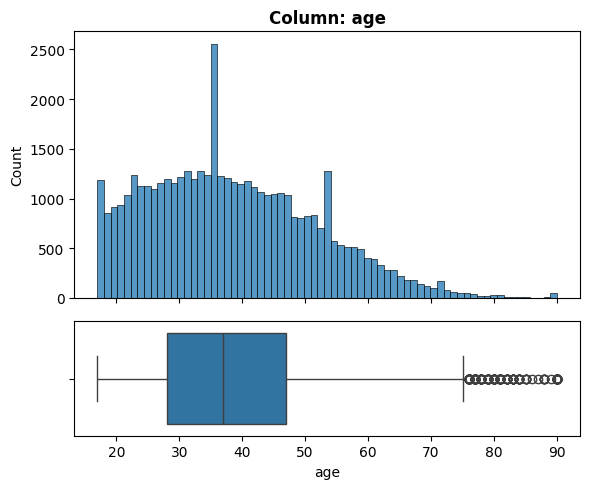

- NaN's Found: 0 (0.0%)
- Unique Values: 74
- Most common value: '36' occurs 1283 times (2.84%)
- Not constant or quasi-constant.


In [140]:
explore_numeric(df, x='age', figsize=(6,5));

**The most common age is 36 years**

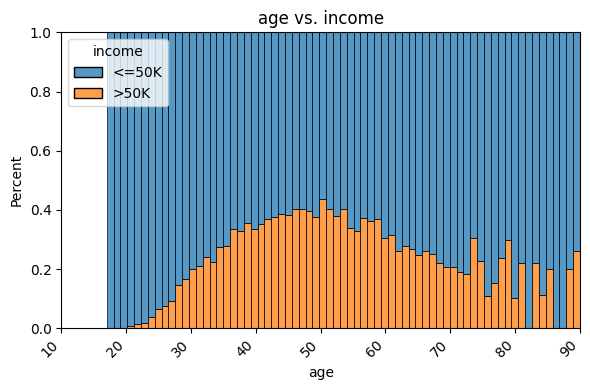

In [141]:
plot_categorical_vs_target(df, x='age', y='income', fillna = False, target_type='class');

**most individuals from 20 years and below earn less than or 50K**

#Model Building

In [142]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOT
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray',colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap,colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  fig.tight_layout()
  plt.show()
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict



In [143]:
#train_test split
from sklearn.model_selection import train_test_split
X = df.drop('income', axis=1)
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(36140, 10)
(9035, 10)
(36140,)
(9035,)


In [144]:
# Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "Missing")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
# Numerical Preprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple],
                                 verbose_feature_names_out=False)



OneHotEncoder Columns: Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object')
Numeric Columns: Index(['age', 'hours-per-week'], dtype='object')


In [145]:
from sklearn.neighbors import KNeighborsClassifier
# Instantiate default KNN
knn = KNeighborsClassifier()



In [146]:
# Define KNN model pipeline
knn_pipe = make_pipeline(preprocessor, knn)
# Fit the model on the training data
knn_pipe.fit(X_train, y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hours-per-week'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.90      0.93      0.91     27131
        >50K       0.76      0.69      0.72      9009

    accuracy                           0.87     36140
   macro avg       0.83      0.81      0.82     36140
weighted avg       0.86      0.87      0.87     36140



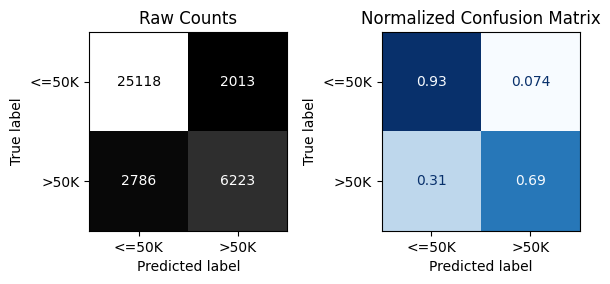


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.87      0.89      0.88      6842
        >50K       0.63      0.59      0.61      2193

    accuracy                           0.82      9035
   macro avg       0.75      0.74      0.74      9035
weighted avg       0.81      0.82      0.81      9035



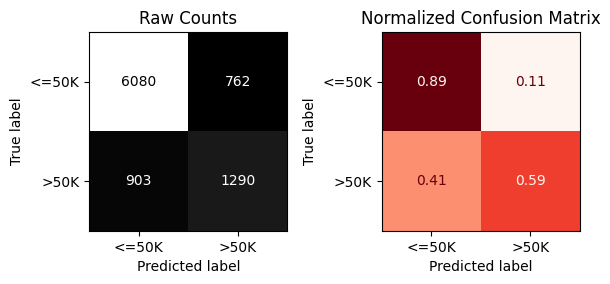

In [147]:
# Obtain evaluation metrics using custom function
evaluate_classification(knn_pipe, X_train, y_train, X_test, y_test)


In [148]:
# Making every other value from the range (odd values)
nneighbors_list = list(range(1,33,2))
nneighbors_list



[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]

In [149]:
# Get list of params for the knn model pipeline
knn_pipe.get_params()



{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['age', 'hours-per-week'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='Missing',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                   

In [150]:
# Create param grid
params={'kneighborsclassifier__n_neighbors': nneighbors_list}



In [151]:
# Instaniate GridSearchCV
gs = GridSearchCV(knn_pipe, params, verbose=True, n_jobs=-1)
# Fit gs on training data
gs.fit(X_train, y_train)
# Obtain best param value for K
gs.best_params_



Fitting 5 folds for each of 16 candidates, totalling 80 fits


{'kneighborsclassifier__n_neighbors': 29}

In [152]:
# Increasing max_columns to see full cv_results
pd.set_option('display.max_columns',50)
# Getting the cv_results as a dataframe
cv_results = pd.DataFrame(gs.cv_results_)
cv_results.head()



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.427491,0.150040,5.035619,1.179385,1,{'kneighborsclassifier__n_neighbors': 1},0.781682,0.782236,0.782097,0.775318,0.778777,0.780022,0.002670,16
1,0.395673,0.122840,5.236831,1.299713,3,{'kneighborsclassifier__n_neighbors': 3},0.811428,0.806032,0.810874,0.802435,0.807277,0.807609,0.003305,15
2,0.358383,0.084779,5.057870,1.124481,5,{'kneighborsclassifier__n_neighbors': 5},0.816270,0.819175,0.814333,0.815163,0.824156,0.817820,0.003567,14
3,0.383710,0.092528,5.317217,1.449489,7,{'kneighborsclassifier__n_neighbors': 7},0.820559,0.822357,0.821389,0.820421,0.826923,0.822330,0.002399,13
4,0.311667,0.017926,4.861262,1.466204,9,{'kneighborsclassifier__n_neighbors': 9},0.821804,0.824986,0.827200,0.821251,0.827476,0.824543,0.002615,12


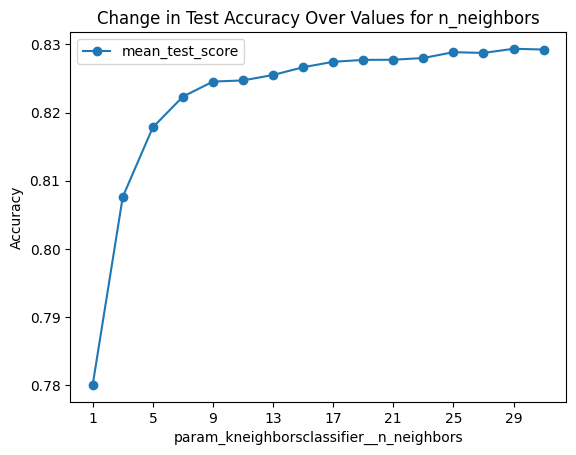

In [153]:
# Plot Accuracy with various values for K
ax = cv_results.plot(x='param_kneighborsclassifier__n_neighbors',
                     y='mean_test_score', style='-o')
ax.set(ylabel="Accuracy", title='Change in Test Accuracy Over Values for n_neighbors');
print()



----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.88      0.91      0.90     27131
        >50K       0.70      0.62      0.66      9009

    accuracy                           0.84     36140
   macro avg       0.79      0.77      0.78     36140
weighted avg       0.84      0.84      0.84     36140



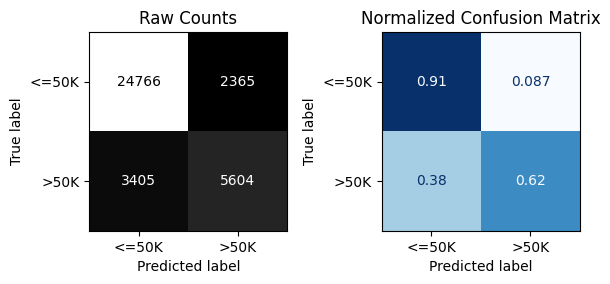


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.87      0.90      0.89      6842
        >50K       0.66      0.60      0.63      2193

    accuracy                           0.83      9035
   macro avg       0.77      0.75      0.76      9035
weighted avg       0.82      0.83      0.82      9035



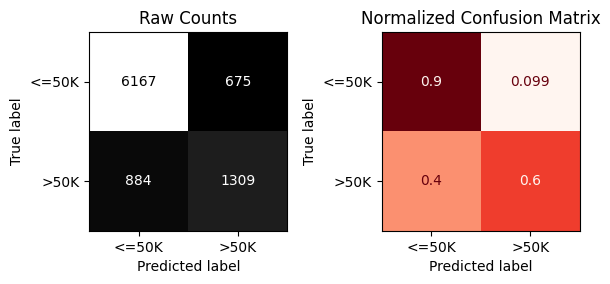

In [154]:
# Obtain complete evaluation for best performing model (k = 21)
evaluate_classification(gs.best_estimator_, X_train, y_train, X_test, y_test)



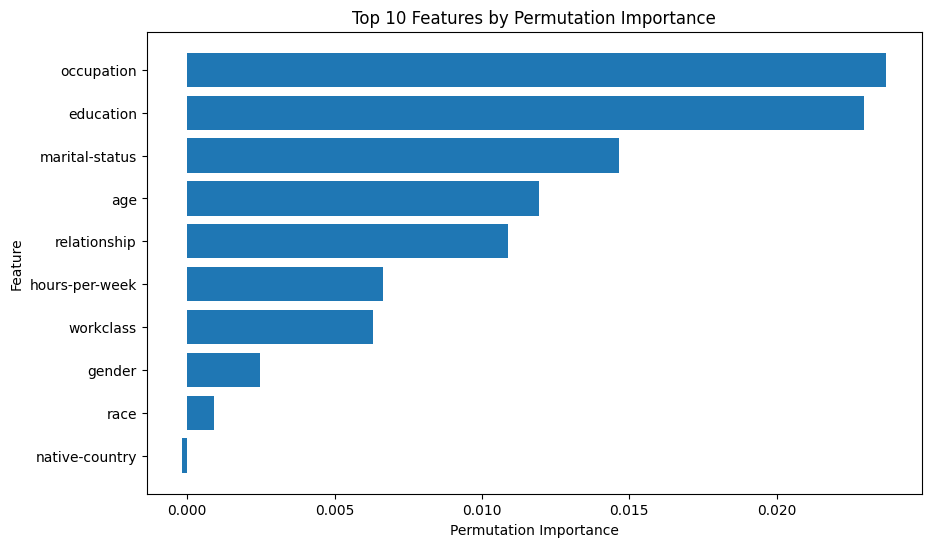

In [156]:
from sklearn.inspection import permutation_importance

# Obtain complete evaluation for best performing model (k = 21)
best_model = gs.best_estimator_

# Calculate permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# Get feature importances and names
feature_importance = perm_importance.importances_mean
feature_names = X_test.columns

# Sort feature importances in descending order and select top 10
top_indices = feature_importance.argsort()[::-1][:10]
top_features = feature_names[top_indices]
top_importance = feature_importance[top_indices]

# Visualize top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importance)
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features by Permutation Importance')
plt.gca().invert_yaxis()
plt.show()

Occupation,Education,marital status,age,and relationship have a great influence on this business case (income)

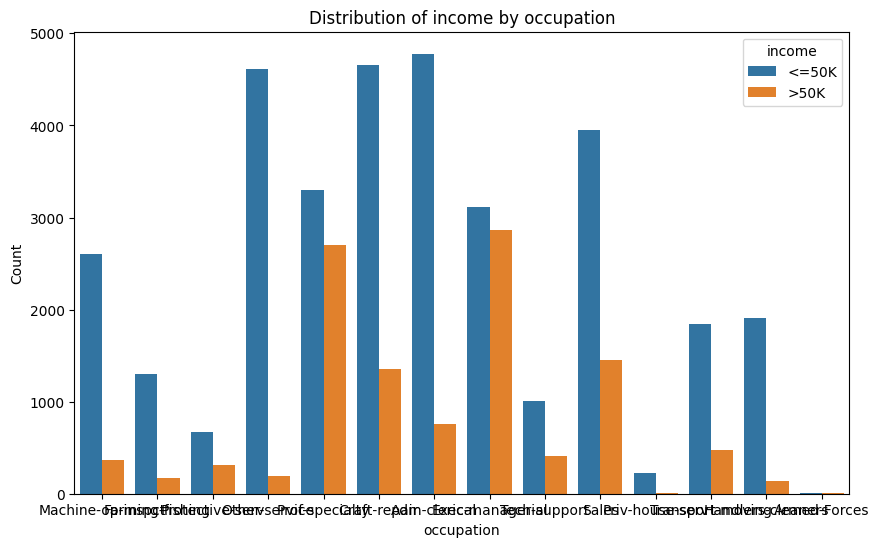

In [157]:
#Select 2 out of the top 10 features from your permutation importances and produce explanatory visualizations showing the relationship between the feature and the target.
#feature 1 occupation and income
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='occupation', hue='income')
plt.xlabel('occupation')
plt.ylabel('Count')
plt.title('Distribution of income by occupation')
plt.show()

From the visualisation,More machine operators earn more than 50k.